## Required packages
numpy, matplotlib, statsmodels, numba, seaborn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
from scipy.optimize import curve_fit
import scipy.stats as st 
from pathlib import Path
import statsmodels.api as sm


from chebAE import chebae

sns.set_style("whitegrid")

sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
# Helper function to simulate the chebAE approach from Quantum 7, 937 (2023) and store output values needed for plots

def simulate_chebAE(amplitude, epsilons, delta, num_mc):   
    np.random.seed(7) # Seed for reproducible results
    errors = np.zeros((len(epsilons), num_mc), dtype = float)
    queries = np.zeros((len(epsilons), num_mc), dtype = float)
    time_complexity = np.zeros((len(epsilons), num_mc), dtype = float)

    for i, eps in enumerate(epsilons):
        q,d,t=0,0,0
        for j in range(num_mc):
            res = chebae(amplitude, eps, delta)
            q += res['queries']
            t += res['time_complexity']
            
            time_complexity[i,j] = res['time_complexity']
            queries[i,j] = res['queries']
            errors[i,j] = np.abs(res['a_hat']-amplitude)

    return errors, queries, time_complexity

In [13]:
def one_parameter_fits(epsilons, queries):   

    epsilons = np.array(epsilons)
    queries = np.array(queries)

    try:
        mod_wls = sm.WLS(epsilons, sm.add_constant(1.0/(queries+1e-50)), weights=1.0 / ((epsilons+1e-50) ** 2))
        res_wls = mod_wls.fit()
        params = res_wls.params[1]
        bse = res_wls.bse[1]
    except:
        print(f'Exception in fitting')
        params = 0
        bse = 0
    
    
    return params, bse

## Data in Table I

In [50]:
# Load precomputed data from run_ae_sims.py and compute fit line to estimate constant factor.
# Average fit line over each amplitude to compute average constant factor independent of a

amplitudes = np.linspace(0.1, 0.9, 9)

#Setup storage containers
C_csae99 = {}
C_csae_time99 = {}
C_csae95 = {}
C_csae_time95 = {}
C_csae68 = {}
C_csae_time68 = {}
C_csae50 = {}
C_csae_time50 = {}

ninetyninepercentile = {}
ninetyfivepercentile = {}
sixtyeightpercentile = {}
median = {}
num_queries = {}
max_single_query = {}
errors = {}
thetas = {}
num_queries99 = {}
max_single_query99 = {}
errors99 = {}
thetas99 = {}

for a in amplitudes:

    # Use a sampling parameter C=1.3 for confidence intervals <= 95%
    dir='sims_C5.0_rel00_mest/'
    with open(dir+f'a{a:0.3f}_mc0500.pkl', 'rb') as handle:
        errors_a, thetas_a, num_queries_a, max_single_query_a, arrays, num_lengths, num_mc = pickle.load(handle)

    # Use a sampling parameter C=1.8 for confidence intervals == 99%
    dir='sims_C5.0_rel00_mest/'
    with open(dir+f'a{a:0.3f}_mc0500.pkl', 'rb') as handle:
        errors99_a, thetas99_a, num_queries99_a, max_single_query99_a, arrays99, num_lengths99, num_mc99 = pickle.load(handle)

    # First 2 are for very high error rates and not useful
    errors[a] = errors_a[2:]
    thetas[a] = thetas_a[2:]
    num_queries[a] = num_queries_a[2:]
    max_single_query[a] = max_single_query_a[2:]
    num_lengths = num_lengths-2

    # First 2 are for very high error rates and not useful
    errors99[a] = errors99_a[2:]
    thetas99[a] = thetas99_a[2:]
    num_queries99[a] = num_queries99_a[2:]
    max_single_query99[a] = max_single_query99_a[2:]
    num_lengths99 = num_lengths99-2

    ninetyninepercentile[a] = np.percentile(errors99[a], 99, axis=1)
    ninetyfivepercentile[a] = np.percentile(errors[a], 95, axis=1)
    sixtyeightpercentile[a] = np.percentile(errors[a], 68, axis=1)
    median[a] = np.percentile(errors[a], 50, axis=1)
    
    C_csae99[a]      = one_parameter_fits(ninetyninepercentile[a], num_queries99[a])
    C_csae_time99[a] = one_parameter_fits(ninetyninepercentile[a], max_single_query99[a])

    C_csae95[a]      = one_parameter_fits(ninetyfivepercentile[a], num_queries[a])
    C_csae_time95[a] = one_parameter_fits(ninetyfivepercentile[a], max_single_query[a])

    C_csae68[a]      = one_parameter_fits(sixtyeightpercentile[a], num_queries[a])
    C_csae_time68[a] = one_parameter_fits(sixtyeightpercentile[a], max_single_query[a])

    C_csae50[a]      = one_parameter_fits(median[a], num_queries[a])
    C_csae_time50[a] = one_parameter_fits(median[a], max_single_query[a])

# Compute max constant and max deviation across amplitudes
C_csae_ave99          = max(C_csae99.values(), key = lambda i: i[0])[0]
C_csae_ave_time99     = max(C_csae_time99.values(), key = lambda i: i[0])[0]
C_csae_ave_dev99      = max(C_csae99.values(), key = lambda i: i[0])[1]
C_csae_ave_time_dev99 = max(C_csae_time99.values(), key = lambda i: i[0])[1]

C_csae_ave95          = max(C_csae95.values(), key = lambda i: i[0])[0]
C_csae_ave_time95     = max(C_csae_time95.values(), key = lambda i: i[0])[0]
C_csae_ave_dev95      = max(C_csae95.values(), key = lambda i: i[0])[1]
C_csae_ave_time_dev95 = max(C_csae_time95.values(), key = lambda i: i[0])[1]

C_csae_ave68          = max(C_csae68.values(), key = lambda i: i[0])[0]
C_csae_ave_time68     = max(C_csae_time68.values(), key = lambda i: i[0])[0]
C_csae_ave_dev68      = max(C_csae68.values(), key = lambda i: i[0])[1]
C_csae_ave_time_dev68 = max(C_csae_time68.values(), key = lambda i: i[0])[1]

C_csae_ave50          = max(C_csae50.values(), key = lambda i: i[0])[0]
C_csae_ave_time50     = max(C_csae_time50.values(), key = lambda i: i[0])[0]
C_csae_ave_dev50      = max(C_csae50.values(), key = lambda i: i[0])[1]
C_csae_ave_time_dev50 = max(C_csae_time50.values(), key = lambda i: i[0])[1]

In [51]:
# Simulates the approach from Quantum 7, 937 (2023) for the output epsilons obtained from the csAE approach 
# for 99%, 95%, 68%, and 50%. Saves the files for future use to save time when plotting.

# Same number of samples as for csAE
num_mc_chebae=500

# Setup storage containers
ave_num_queries_chebae99 = {}
max_num_queries_chebae99 = {}
min_num_queries_chebae99 = {}
ave_time_complexity_chebae99 = {}
max_time_complexity_chebae99 = {}
min_time_complexity_chebae99 = {}
errors_chebae99 = {}
queries_chebae99 = {}
time_complexity_chebae99 = {}

ave_num_queries_chebae95 = {}
max_num_queries_chebae95 = {}
min_num_queries_chebae95 = {}
ave_time_complexity_chebae95 = {}
max_time_complexity_chebae95 = {}
min_time_complexity_chebae95 = {}
errors_chebae95 = {}
queries_chebae95 = {}
time_complexity_chebae95 = {}

ave_num_queries_chebae68 = {}
max_num_queries_chebae68 = {}
min_num_queries_chebae68 = {}
ave_time_complexity_chebae68 = {}
max_time_complexity_chebae68 = {}
min_time_complexity_chebae68 = {}
errors_chebae68 = {}
queries_chebae68 = {}
time_complexity_chebae68 = {}

ave_num_queries_chebae50 = {}
max_num_queries_chebae50 = {}
min_num_queries_chebae50 = {}
ave_time_complexity_chebae50 = {}
max_time_complexity_chebae50 = {}
min_time_complexity_chebae50 = {}
errors_chebae50 = {}
queries_chebae50 = {}
time_complexity_chebae50 = {}

ninetyninepercentile_chebae = {}
ninetyfivepercentile_chebae = {}
sixtyeightpercentile_chebae = {}
median_chebae = {}


C_cheb99          = {}
C_cheb_max99      = {}
C_cheb_time99     = {}
C_cheb_time_max99 = {}

C_cheb95          = {}
C_cheb_max95      = {}
C_cheb_time95     = {}
C_cheb_time_max95 = {}

C_cheb68          = {}
C_cheb_max68      = {}
C_cheb_time68     = {}
C_cheb_time_max68 = {}

C_cheb50          = {}
C_cheb_max50      = {}
C_cheb_time50     = {}
C_cheb_time_max50 = {}

# Load or simulate chebAE for confidence levels 99%, 95%, 68%, and 50% for each amplitude
for a in amplitudes:
    print(f'a={a:0.3f}')

    chebae_file = dir+f'chebae_a{a:0.3f}_mc{num_mc_chebae:04d}_99.pkl'
    if Path(chebae_file).is_file():
        # file exists
        print('99% ChebAE Load')
        with open(chebae_file, 'rb') as handle:
            errors_chebae99[a], queries_chebae99[a], time_complexity_chebae99[a] = pickle.load(handle)
    else:
        print('99% ChebAE Sim')
        errors_chebae99[a], queries_chebae99[a], time_complexity_chebae99[a] = \
            simulate_chebAE(amplitude=a, epsilons=ninetyninepercentile[a], delta=0.01, num_mc=num_mc_chebae)
        with open(chebae_file, 'wb') as handle:
            pickle.dump((errors_chebae99[a], queries_chebae99[a], time_complexity_chebae99[a]), 
                        handle, protocol=pickle.HIGHEST_PROTOCOL)  

    # compute the average, max, and min number of queries both for total complexity and time complexity.
    # Time complexity is the maximum coherent depth and indicates the parallelizability of the algorithm
    ave_num_queries_chebae99[a]     = np.mean(queries_chebae99[a], axis=1)
    max_num_queries_chebae99[a]     = np.max(queries_chebae99[a], axis=1)
    min_num_queries_chebae99[a]     = np.min(queries_chebae99[a], axis=1)
    ave_time_complexity_chebae99[a] = np.mean(time_complexity_chebae99[a], axis=1)
    max_time_complexity_chebae99[a] = np.max(time_complexity_chebae99[a], axis=1)
    min_time_complexity_chebae99[a] = np.min(time_complexity_chebae99[a], axis=1)
    ninetyninepercentile_chebae[a]  = np.percentile(errors_chebae99[a], 99, axis=1)

    # Fit the curves to get the constant factor
    C_cheb99[a]          = one_parameter_fits(ninetyninepercentile_chebae[a], ave_num_queries_chebae99[a])
    C_cheb_max99[a]      = one_parameter_fits(ninetyninepercentile_chebae[a], max_num_queries_chebae99[a])
    C_cheb_time99[a]     = one_parameter_fits(ninetyninepercentile_chebae[a], ave_time_complexity_chebae99[a])
    C_cheb_time_max99[a] = one_parameter_fits(ninetyninepercentile_chebae[a], max_time_complexity_chebae99[a])

    # Do the same for the rest of the percentiles. Probably should be done in a function, but this is the lazy way.
    chebae_file = dir+f'chebae_a{a:0.3f}_mc{num_mc_chebae:04d}_95.pkl'
    if Path(chebae_file).is_file():
        # file exists
        print('95% ChebAE Load')
        with open(chebae_file, 'rb') as handle:
            errors_chebae95[a], queries_chebae95[a], time_complexity_chebae95[a] = pickle.load(handle)
    else:
        print('95% ChebAE Sim')
        errors_chebae95[a], queries_chebae95[a], time_complexity_chebae95[a] = \
            simulate_chebAE(amplitude=a, epsilons=ninetyfivepercentile[a], delta=0.05, num_mc=num_mc_chebae)
        with open(chebae_file, 'wb') as handle:
            pickle.dump((errors_chebae95[a], queries_chebae95[a], time_complexity_chebae95[a]), 
                        handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
    ave_num_queries_chebae95[a]     = np.mean(queries_chebae95[a], axis=1)
    max_num_queries_chebae95[a]     = np.max(queries_chebae95[a], axis=1)
    min_num_queries_chebae95[a]     = np.min(queries_chebae95[a], axis=1)
    ave_time_complexity_chebae95[a] = np.mean(time_complexity_chebae95[a], axis=1)
    max_time_complexity_chebae95[a] = np.max(time_complexity_chebae95[a], axis=1)
    min_time_complexity_chebae95[a] = np.min(time_complexity_chebae95[a], axis=1)
    ninetyfivepercentile_chebae[a]  = np.percentile(errors_chebae95[a], 95, axis=1)
    
    C_cheb95[a]          = one_parameter_fits(ninetyfivepercentile_chebae[a], ave_num_queries_chebae95[a])
    C_cheb_max95[a]      = one_parameter_fits(ninetyfivepercentile_chebae[a], max_num_queries_chebae95[a])
    C_cheb_time95[a]     = one_parameter_fits(ninetyfivepercentile_chebae[a], ave_time_complexity_chebae95[a])
    C_cheb_time_max95[a] = one_parameter_fits(ninetyfivepercentile_chebae[a], max_time_complexity_chebae95[a])
    
    chebae_file = dir+f'chebae_a{a:0.3f}_mc{num_mc_chebae:04d}_68.pkl'
    if Path(chebae_file).is_file():
        # file exists
        print('68% ChebAE Load')
        with open(chebae_file, 'rb') as handle:
            errors_chebae68[a], queries_chebae68[a], time_complexity_chebae68[a] = pickle.load(handle)
    else:
        print('68% ChebAE Sim')
        errors_chebae68[a], queries_chebae68[a], time_complexity_chebae68[a] = \
            simulate_chebAE(amplitude=a, epsilons=sixtyeightpercentile[a], delta=0.32, num_mc=num_mc_chebae)
        with open(chebae_file, 'wb') as handle:
            pickle.dump((errors_chebae68[a], queries_chebae68[a], time_complexity_chebae68[a]), 
                        handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
    ave_num_queries_chebae68[a]     = np.mean(queries_chebae68[a], axis=1)
    max_num_queries_chebae68[a]     = np.max(queries_chebae68[a], axis=1)
    min_num_queries_chebae68[a]     = np.min(queries_chebae68[a], axis=1)
    ave_time_complexity_chebae68[a] = np.mean(time_complexity_chebae68[a], axis=1)
    max_time_complexity_chebae68[a] = np.max(time_complexity_chebae68[a], axis=1)
    min_time_complexity_chebae68[a] = np.min(time_complexity_chebae68[a], axis=1)
    sixtyeightpercentile_chebae[a]  = np.percentile(errors_chebae68[a], 68, axis=1)
    
    C_cheb68[a]          = one_parameter_fits(sixtyeightpercentile_chebae[a], ave_num_queries_chebae68[a])
    C_cheb_max68[a]      = one_parameter_fits(sixtyeightpercentile_chebae[a], max_num_queries_chebae68[a])
    C_cheb_time68[a]     = one_parameter_fits(sixtyeightpercentile_chebae[a], ave_time_complexity_chebae68[a])
    C_cheb_time_max68[a] = one_parameter_fits(sixtyeightpercentile_chebae[a], max_time_complexity_chebae68[a])
    
    chebae_file = dir+f'chebae_a{a:0.3f}_mc{num_mc_chebae:04d}_50.pkl'
    if Path(chebae_file).is_file():
        # file exists
        print('50% ChebAE Load')
        with open(chebae_file, 'rb') as handle:
            errors_chebae50[a], queries_chebae50[a], time_complexity_chebae50[a] = pickle.load(handle)
    else:    
        print('50% ChebAE Sim')
        errors_chebae50[a], queries_chebae50[a], time_complexity_chebae50[a] = \
            simulate_chebAE(amplitude=a, epsilons=median[a], delta=0.5, num_mc=num_mc_chebae)
        with open(chebae_file, 'wb') as handle:
            pickle.dump((errors_chebae50[a], queries_chebae50[a], time_complexity_chebae50[a]), 
                        handle, protocol=pickle.HIGHEST_PROTOCOL) 
    
    ave_num_queries_chebae50[a]     = np.mean(queries_chebae50[a], axis=1)
    max_num_queries_chebae50[a]     = np.max(queries_chebae50[a], axis=1)
    min_num_queries_chebae50[a]     = np.min(queries_chebae50[a], axis=1)
    ave_time_complexity_chebae50[a] = np.mean(time_complexity_chebae50[a], axis=1)
    max_time_complexity_chebae50[a] = np.max(time_complexity_chebae50[a], axis=1)
    min_time_complexity_chebae50[a] = np.min(time_complexity_chebae50[a], axis=1)
    median_chebae[a]                = np.percentile(errors_chebae50[a], 50, axis=1)
    
    C_cheb50[a]          = one_parameter_fits(median_chebae[a], ave_num_queries_chebae50[a])
    C_cheb_max50[a]      = one_parameter_fits(median_chebae[a], max_num_queries_chebae50[a])
    C_cheb_time50[a]     = one_parameter_fits(median_chebae[a], ave_time_complexity_chebae50[a])
    C_cheb_time_max50[a] = one_parameter_fits(median_chebae[a], max_time_complexity_chebae50[a])


# Compute max complexity and max deviation across amplitudes
C_cheb_ave99          = max(C_cheb99.values(), key = lambda i: i[0])[0]
C_cheb_ave_time99     = max(C_cheb_time99.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev99      = max(C_cheb99.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev99 = max(C_cheb_time99.values(), key = lambda i: i[0])[1]

C_cheb_ave_max99          = max(C_cheb_max99.values(), key = lambda i: i[0])[0]
C_cheb_ave_time_max99     = max(C_cheb_time_max99.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev_max99      = max(C_cheb_max99.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev_max99 = max(C_cheb_time_max99.values(), key = lambda i: i[0])[1]

C_cheb_ave95          = max(C_cheb95.values(), key = lambda i: i[0])[0]
C_cheb_ave_time95     = max(C_cheb_time95.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev95      = max(C_cheb95.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev95 = max(C_cheb_time95.values(), key = lambda i: i[0])[1]

C_cheb_ave_max95          = max(C_cheb_max95.values(), key = lambda i: i[0])[0]
C_cheb_ave_time_max95     = max(C_cheb_time_max95.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev_max95      = max(C_cheb_max95.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev_max95 = max(C_cheb_time_max95.values(), key = lambda i: i[0])[1]

C_cheb_ave68          = max(C_cheb68.values(), key = lambda i: i[0])[0]
C_cheb_ave_time68     = max(C_cheb_time68.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev68      = max(C_cheb68.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev68 = max(C_cheb_time68.values(), key = lambda i: i[0])[1]

C_cheb_ave_max68          = max(C_cheb_max68.values(), key = lambda i: i[0])[0]
C_cheb_ave_time_max68     = max(C_cheb_time_max68.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev_max68      = max(C_cheb_max68.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev_max68 = max(C_cheb_time_max68.values(), key = lambda i: i[0])[1]

C_cheb_ave50          = max(C_cheb50.values(), key = lambda i: i[0])[0]
C_cheb_ave_time50     = max(C_cheb_time50.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev50      = max(C_cheb50.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev50 = max(C_cheb_time50.values(), key = lambda i: i[0])[1]

C_cheb_ave_max50          = max(C_cheb_max50.values(), key = lambda i: i[0])[0]
C_cheb_ave_time_max50     = max(C_cheb_time_max50.values(), key = lambda i: i[0])[0]
C_cheb_ave_dev_max50      = max(C_cheb_max50.values(), key = lambda i: i[0])[1]
C_cheb_ave_time_dev_max50 = max(C_cheb_time_max50.values(), key = lambda i: i[0])[1]

a=0.100
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.200
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.300
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.400
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.500
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.600
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.700
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.800
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim
a=0.900
99% ChebAE Sim
95% ChebAE Sim
68% ChebAE Sim
50% ChebAE Sim


# Table 1 parameters

In [52]:
# Gets the fit parameters for csA and chebAE for both total query complexity as well as parallel query complexity (denoted as time). 
# This is the query complexity assuming access to as many quantum computers as required to fully parallelize the problem.

# Computes fits for both average case and worst case for chebAE. For csAE there is no variation in schedule, so 
# average case and worst case are the same. 

print('99% Fits Average Case')
print(f'  99% CS Sequential Constant Factor: {C_csae_ave99:0.3f} +- {C_csae_ave_dev99:0.3f}')
print(f'  99% CS Parallel Constant Factor: {C_csae_ave_time99:0.3f}  +- {C_csae_ave_time_dev99:0.3f}')
print(f'  99% Cheb Sequential Constant Factor: {C_cheb_ave99:0.3f} +- {C_cheb_ave_dev99:0.3f}')
print(f'  99% Cheb Parallel Constant Factor: {C_cheb_ave_time99:0.3f} +- {C_cheb_ave_time_dev99:0.3f}')
print(f'  99% Sequential Ratio: {C_cheb_ave99/C_csae_ave99:0.3f}')
print(f'  99% Parallel Ratio: {C_cheb_ave_time99/C_csae_ave_time99:0.3f}')

print('\n\n95% Fits Average Case')

print(f'  95% CS Sequential Constant Factor: {C_csae_ave95:0.3f} +- {C_csae_ave_dev95:0.3f}')
print(f'  95% CS Parallel Constant Factor: {C_csae_ave_time95:0.3f}  +- {C_csae_ave_time_dev95:0.3f}')
print(f'  95% Cheb Sequential Constant Factor: {C_cheb_ave95:0.3f} +- {C_cheb_ave_dev95:0.3f}')
print(f'  95% Cheb Parallel Constant Factor: {C_cheb_ave_time95:0.3f} +- {C_cheb_ave_time_dev95:0.3f}')
print(f'  95% Sequential Ratio: {C_cheb_ave95/C_csae_ave95:0.3f}')
print(f'  95% Parallel Ratio: {C_cheb_ave_time95/C_csae_ave_time95:0.3f}')

print('\n\n68% Fits Average Case')

print(f'  68% CS Sequential Constant Factor: {C_csae_ave68:0.3f} +- {C_csae_ave_dev68:0.3f}')
print(f'  68% CS Parallel Constant Factor: {C_csae_ave_time68:0.3f}  +- {C_csae_ave_time_dev68:0.3f}')
print(f'  68% Cheb Sequential Constant Factor: {C_cheb_ave68:0.3f} +- {C_cheb_ave_dev68:0.3f}')
print(f'  68% Cheb Parallel Constant Factor: {C_cheb_ave_time68:0.3f} +- {C_cheb_ave_time_dev68:0.3f}')
print(f'  68% Sequential Ratio: {C_cheb_ave68/C_csae_ave68:0.3f}')
print(f'  68% Parallel Ratio: {C_cheb_ave_time68/C_csae_ave_time68:0.3f}')

print('\n\nMedian Fits Average Case')

print(f'  50% CS Sequential Constant Factor: {C_csae_ave50:0.3f} +- {C_csae_ave_dev50:0.3f}')
print(f'  50% CS Parallel Constant Factor: {C_csae_ave_time50:0.3f}  +- {C_csae_ave_time_dev50:0.3f}')
print(f'  50% Cheb Sequential Constant Factor: {C_cheb_ave50:0.3f} +- {C_cheb_ave_dev50:0.3f}')
print(f'  50% Cheb Parallel Constant Factor: {C_cheb_ave_time50:0.3f} +- {C_cheb_ave_time_dev50:0.3f}')
print(f'  50% Sequential Ratio: {C_cheb_ave50/C_csae_ave50:0.3f}')
print(f'  50% Parallel Ratio: {C_cheb_ave_time50/C_csae_ave_time50:0.3f}')



print('\n\n99% Fits Worst Case')
print(f'  99% CS Sequential Constant Factor: {C_csae_ave99:0.3f} +- {C_csae_ave_dev99:0.3f}')
print(f'  99% CS Parallel Constant Factor: {C_csae_ave_time99:0.3f} +- {C_csae_ave_time_dev99:0.3f}')
print(f'  99% Cheb Sequential Constant Factor: {C_cheb_ave_max99:0.3f} +- {C_cheb_ave_dev_max99:0.3f}')
print(f'  99% Cheb Parallel Constant Factor: {C_cheb_ave_time_max99:0.3f} +- {C_cheb_ave_time_dev_max99:0.3f}')
print(f'  99% Sequential Ratio Max: {C_cheb_ave_max99/C_csae_ave99:0.3f}')
print(f'  99% Parallel Ratio Max: {C_cheb_ave_time_max99/C_csae_ave_time99:0.3f}')

print('\n\n95% Fits Worst Case')

print(f'  95% CS Sequential Constant Factor: {C_csae_ave95:0.3f} +- {C_csae_ave_dev95:0.3f}')
print(f'  95% CS Parallel Constant Factor: {C_csae_ave_time95:0.3f} +- {C_csae_ave_time_dev95:0.3f}')
print(f'  95% Cheb Sequential Constant Factor: {C_cheb_ave_max95:0.3f} +- {C_cheb_ave_dev_max95:0.3f}')
print(f'  95% Cheb Parallel Constant Factor: {C_cheb_ave_time_max95:0.3f} +- {C_cheb_ave_time_dev_max95:0.3f}')
print(f'  95% Sequential Ratio Max: {C_cheb_ave_max95/C_csae_ave95:0.3f}')
print(f'  95% Parallel Ratio Max: {C_cheb_ave_time_max95/C_csae_ave_time95:0.3f}')

print('\n\n68% Fits Worst Case')

print(f'  68% CS Sequential Constant Factor: {C_csae_ave68:0.3f} +- {C_csae_ave_dev68:0.3f}')
print(f'  68% CS Parallel Constant Factor: {C_csae_ave_time68:0.3f} +- {C_csae_ave_time_dev68:0.3f}')
print(f'  68% Cheb Sequential Constant Factor: {C_cheb_ave_max68:0.3f} +- {C_cheb_ave_dev_max68:0.3f}')
print(f'  68% Cheb Parallel Constant Factor: {C_cheb_ave_time_max68:0.3f} +- {C_cheb_ave_time_dev_max68:0.3f}')
print(f'  68% Sequential Ratio Max: {C_cheb_ave_max68/C_csae_ave68:0.3f}')
print(f'  68% Parallel Ratio Max: {C_cheb_ave_time_max68/C_csae_ave_time68:0.3f}')

print('\n\nMedian Fits Worst Case')

print(f'  50% CS Sequential Constant Factor: {C_csae_ave50:0.3f} +- {C_csae_ave_dev50:0.3f}')
print(f'  50% CS Parallel Constant Factor: {C_csae_ave_time50:0.3f} +- {C_csae_ave_time_dev50:0.3f}')
print(f'  50% Cheb Sequential Constant Factor: {C_cheb_ave_max50:0.3f} +- {C_cheb_ave_dev_max50:0.3f}')
print(f'  50% Cheb Parallel Constant Factor: {C_cheb_ave_time_max50:0.3f} +- {C_cheb_ave_time_dev_max50:0.3f}')
print(f'  50% Sequential Ratio Max: {C_cheb_ave_max50/C_csae_ave50:0.3f}')
print(f'  50% Parallel Ratio Max: {C_cheb_ave_time_max50/C_csae_ave_time50:0.3f}')

99% Fits Average Case
  99% CS Sequential Constant Factor: 4.982 +- 1.261
  99% CS Parallel Constant Factor: 0.250  +- 0.063
  99% Cheb Sequential Constant Factor: 6.149 +- 0.369
  99% Cheb Parallel Constant Factor: 5.687 +- 0.343
  99% Sequential Ratio: 1.234
  99% Parallel Ratio: 22.736


95% Fits Average Case
  95% CS Sequential Constant Factor: 4.982 +- 1.261
  95% CS Parallel Constant Factor: 0.250  +- 0.063
  95% Cheb Sequential Constant Factor: 4.009 +- 0.168
  95% Cheb Parallel Constant Factor: 3.663 +- 0.140
  95% Sequential Ratio: 0.805
  95% Parallel Ratio: 14.645


68% Fits Average Case
  68% CS Sequential Constant Factor: 4.982 +- 1.261
  68% CS Parallel Constant Factor: 0.250  +- 0.063
  68% Cheb Sequential Constant Factor: 1.645 +- 0.032
  68% Cheb Parallel Constant Factor: 1.470 +- 0.025
  68% Sequential Ratio: 0.330
  68% Parallel Ratio: 5.875


Median Fits Average Case
  50% CS Sequential Constant Factor: 4.982 +- 1.261
  50% CS Parallel Constant Factor: 0.250  +- 0.0

## Fig. 3 95%

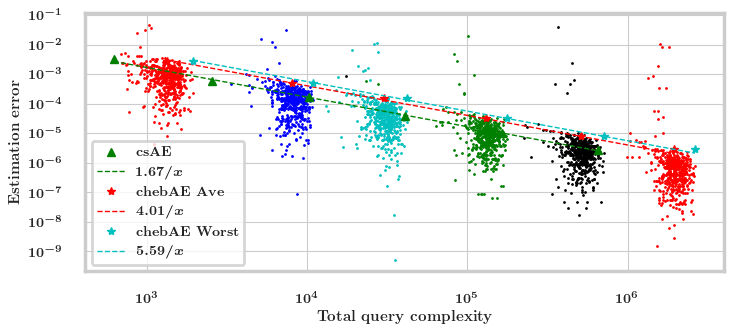

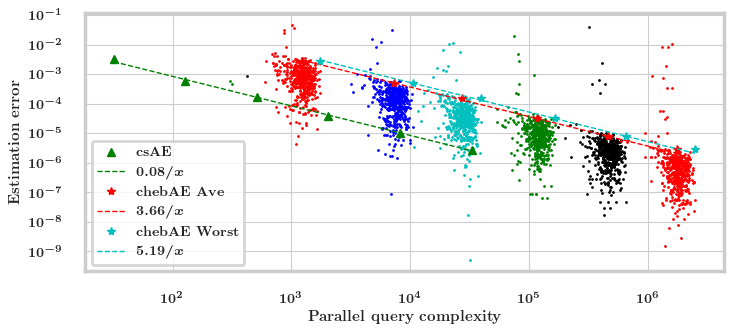

In [53]:
ms=2
lw=1
sns.set_style("whitegrid")

a=0.5

#QUERY COMPLEXITY
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([num_queries[a][k]]*num_mc, errors[a][k], colors[k % len(colors)], ms=ms)
    plt.plot(queries_chebae95[a][k], errors_chebae95[a][k], colors[k % len(colors)], ms=ms)

plt.plot(num_queries[a], ninetyfivepercentile[a], '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(num_queries[a], C_csae95[a][0]/(num_queries[a]), '--g', label=rf'${C_csae95[a][0]:.2f}/x$', linewidth=1)
plt.plot(ave_num_queries_chebae95[a], ninetyfivepercentile_chebae[a], '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_num_queries_chebae95[a], C_cheb95[a][0]/(ave_num_queries_chebae95[a]), '--r', label=rf'${C_cheb95[a][0]:.2f}/x$', linewidth=1)
plt.plot(max_num_queries_chebae95[a], ninetyfivepercentile_chebae[a], '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_num_queries_chebae95[a], C_cheb_max95[a][0]/(max_num_queries_chebae95[a]), '--c', label=rf'${C_cheb_max95[a][0]:.2f}/x$', linewidth=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Total query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig('figs/a5_max_query.pdf')

# TIME COMPLEXITY
plt.figure()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([max_single_query[a][k]]*num_mc, errors[a][k], colors[k % len(colors)], ms=ms)
    plt.plot(time_complexity_chebae95[a][k], errors_chebae95[a][k], colors[k % len(colors)], ms=ms)

   
# plt.plot(max_single_query, 0.1/(max_single_query), 'r', linewidth=1)
plt.plot(max_single_query[a], ninetyfivepercentile[a], '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(max_single_query[a], C_csae_time95[a][0]/(max_single_query[a]), '--g', label=rf'${C_csae_time95[a][0]:.2f}/x$', linewidth=1)
plt.plot(ave_time_complexity_chebae95[a], ninetyfivepercentile_chebae[a], '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_time_complexity_chebae95[a], C_cheb_time95[a][0]/(ave_time_complexity_chebae95[a]), '--r', label=rf'${C_cheb_time95[a][0]:.2f}/x$', linewidth=1)
plt.plot(max_time_complexity_chebae95[a], ninetyfivepercentile_chebae[a], '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_time_complexity_chebae95[a], C_cheb_time_max95[a][0]/(max_time_complexity_chebae95[a]), '--c', label=rf'${C_cheb_time_max95[a][0]:.2f}/x$', linewidth=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Parallel query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig('figs/a5_max_time.pdf')

## Fig 3 99% (Not shown in paper)

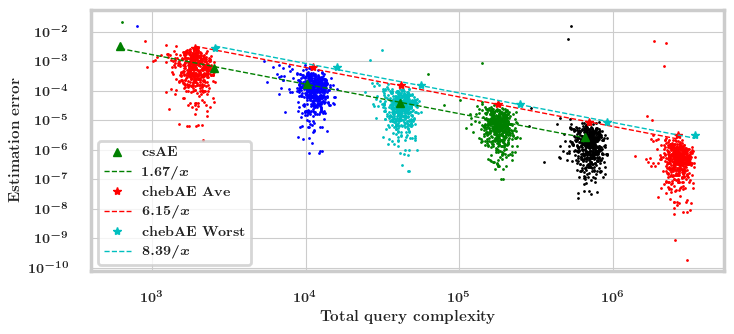

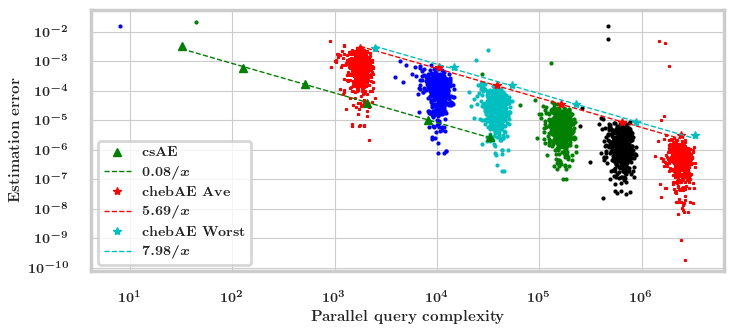

In [54]:
ms=2
lw=1
sns.set_style("whitegrid")

a=0.5

#QUERY COMPLEXITY
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([num_queries99[a][k]]*num_mc, errors99[a][k], colors[k % len(colors)], ms=ms)
    plt.plot(queries_chebae99[a][k], errors_chebae99[a][k], colors[k % len(colors)], ms=ms)


plt.plot(num_queries99[a], ninetyninepercentile[a], '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(num_queries99[a], C_csae99[a][0]/(num_queries[a]), '--g', label=rf'${C_csae99[a][0]:.2f}/x$', linewidth=1)
plt.plot(ave_num_queries_chebae99[a], ninetyninepercentile_chebae[a], '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_num_queries_chebae99[a], C_cheb99[a][0]/(ave_num_queries_chebae99[a]), '--r', label=rf'${C_cheb99[a][0]:.2f}/x$', linewidth=1)
plt.plot(max_num_queries_chebae99[a], ninetyninepercentile_chebae[a], '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_num_queries_chebae99[a], C_cheb_max99[a][0]/(max_num_queries_chebae99[a]), '--c', label=rf'${C_cheb_max99[a][0]:.2f}/x$', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Total query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig('figs/a5_query99.pdf')

# TIME COMPLEXITY
plt.figure()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
colors_cheb = ['r*', 'bo', 'co', 'go', 'ko']
for k in range(num_lengths):
    plt.plot([max_single_query99[a][k]]*num_mc, errors99[a][k], colors[k % len(colors)], ms=ms)
    plt.plot(time_complexity_chebae99[a][k], errors_chebae99[a][k], colors_cheb[k % len(colors)], ms=ms)


plt.plot(max_single_query99[a], ninetyninepercentile[a], '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(max_single_query99[a], C_csae_time99[a][0]/(max_single_query[a]), '--g', label=rf'${C_csae_time99[a][0]:.2f}/x$', linewidth=1)
plt.plot(ave_time_complexity_chebae99[a], ninetyninepercentile_chebae[a], '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_time_complexity_chebae99[a], C_cheb_time99[a][0]/(ave_time_complexity_chebae99[a]), '--r', label=rf'${C_cheb_time99[a][0]:.2f}/x$', linewidth=1)
plt.plot(max_time_complexity_chebae99[a], ninetyninepercentile_chebae[a], '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_time_complexity_chebae99[a], C_cheb_time_max99[a][0]/(max_time_complexity_chebae99[a]), '--c', label=rf'${C_cheb_time_max99[a][0]:.2f}/x$', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Parallel query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig('figs/a5_time99.pdf')

## Calculate the Expected Shortfall for both chebAE and csAE (Not shown in paper)

Here we calculate the expected error if we happen to fall in the region outside the $\delta$ confidence level. These results are not shown in the paper. Specifically what this computes is the mean of the error values above the 99%, 95% and 68% error targets respectively. This tells you in a sense, if this algorithm fails, how badly does it fail. We find our approach is generally better, especially for lower confidence levels where it can be orders of magnitude better than chebAE.

In [55]:
a = 0.5 # Do the calculation for amplitude a = 0.5

csae_es_99 = []
csae_es_95 = []
csae_es_68 = []
for err_index in range(len(errors[a])):
    errors_95 = 0
    errors_68 = 0
    es_95 = 0.0
    es_68 = 0.0
    for error in errors[a][err_index]:
        if error >= ninetyfivepercentile[a][err_index]:
            errors_95 += 1
            es_95 += error
        if error >= sixtyeightpercentile[a][err_index]:
            errors_68 += 1
            es_68 += error
    
    csae_es_95.append(es_95/errors_95)
    csae_es_68.append(es_68/errors_68)

for err_index in range(len(errors99[a])):
    errors_99 = 0
    es_99 = 0.0
    for error in errors99[a][err_index]:
        if error >= ninetyninepercentile[a][err_index]:
            errors_99 += 1
            es_99 += error
    
    csae_es_99.append(es_99/errors_99)

In [56]:
chebae_es_99 = []
chebae_es_95 = []
chebae_es_68 = []
for err_index in range(len(errors_chebae95[a])):
    errors_99 = 0
    errors_95 = 0
    errors_68 = 0
    es_99 = 0.0
    es_95 = 0.0
    es_68 = 0.0
    for error in errors_chebae99[a][err_index]:
        if error >= ninetyninepercentile_chebae[a][err_index]:
            errors_99 += 1
            es_99 += error
    for error in errors_chebae95[a][err_index]:
        if error >= ninetyfivepercentile_chebae[a][err_index]:
            errors_95 += 1
            es_95 += error
    for error in errors_chebae68[a][err_index]:
        if error >= sixtyeightpercentile_chebae[a][err_index]:
            errors_68 += 1
            es_68 += error
    
    chebae_es_99.append(es_99/errors_99)
    chebae_es_95.append(es_95/errors_95)
    chebae_es_68.append(es_68/errors_68)


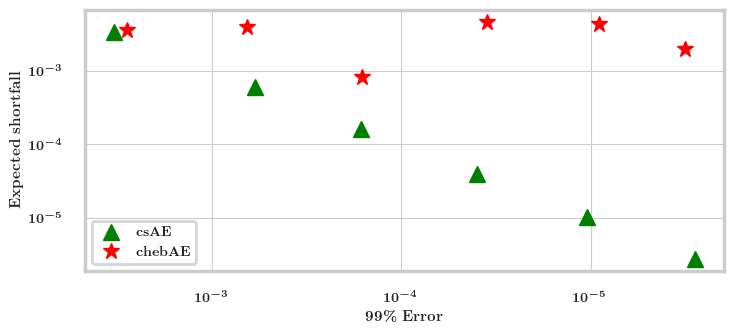

In [57]:
plt.plot(ninetyninepercentile[a],csae_es_99, "^g", label=r'\textbf{csAE}')
plt.plot(ninetyninepercentile_chebae[a],chebae_es_99, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{99\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

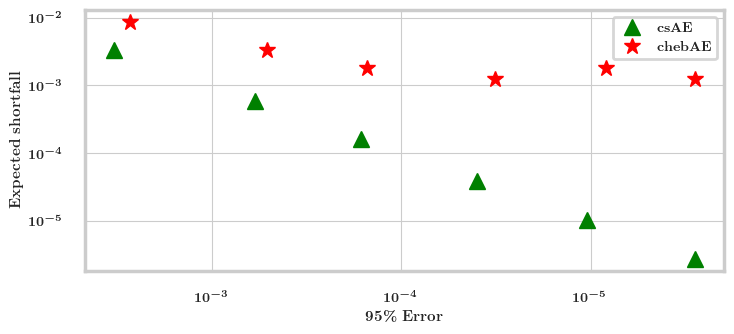

In [58]:
plt.plot(ninetyfivepercentile[a],csae_es_95, "^g", label=r'\textbf{csAE}')
plt.plot(ninetyfivepercentile_chebae[a],chebae_es_95, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{95\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

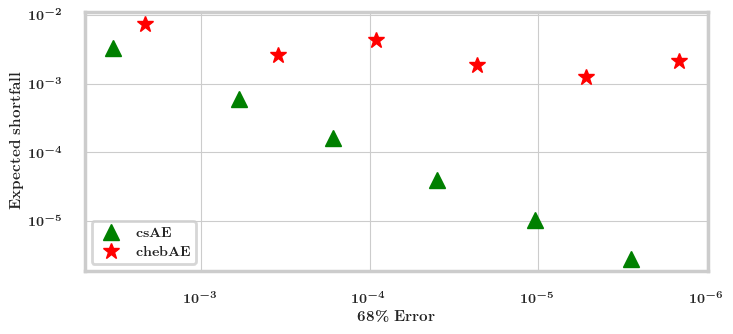

In [59]:
plt.plot(sixtyeightpercentile[a],csae_es_68, "^g", label=r'\textbf{csAE}')
plt.plot(sixtyeightpercentile_chebae[a],chebae_es_68, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{68\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

# Fig. 4 Constant factor vs Amplitude

In [60]:
# Load noisy simulations

def load_sims(dir, amplitudes, percentile=95, idx=4):

    C = []
    C_time = []
    
    for a in amplitudes:
        filename = dir+f'a{a:0.3f}_mc0500.pkl'
        
        with open(filename, 'rb') as handle:
            errors, thetas, num_queries, max_single_query, arrays, num_lengths, num_mc = pickle.load(handle)

        p_error = np.percentile(errors, percentile, axis=1)

        C.append(p_error[idx]*num_queries[idx])
        C_time.append(p_error[idx]*max_single_query[idx])

    return C, C_time

cs_C_eta = {}
cs_C_eta_time = {}
etas = ['1e-4', '1e-5', '1e-6']
for eta in etas:
    dir = 'sims_C1.5_eta'+eta+'_final/'
    temp = load_sims(dir, amplitudes)
    cs_C_eta[eta] = temp[0]
    cs_C_eta_time[eta] = temp[1]

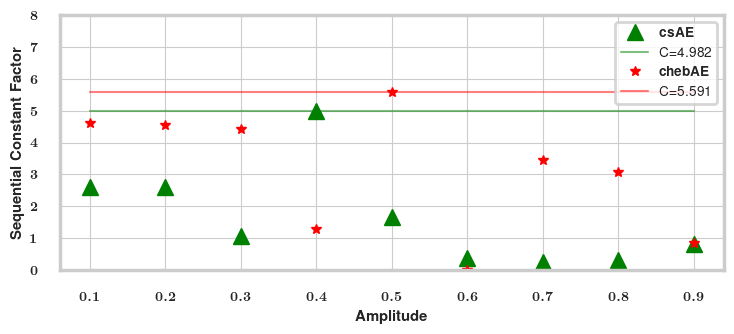

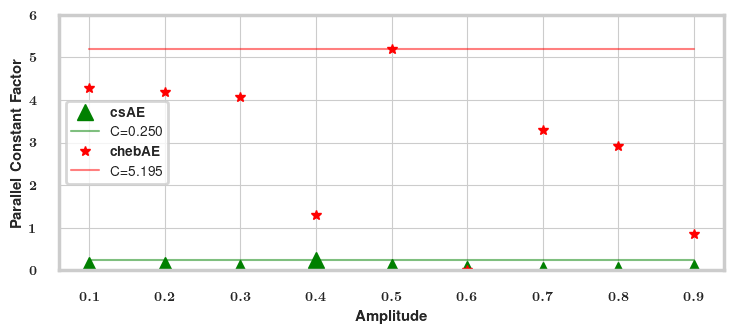

In [61]:
ms=7
lw=1.5

sns.set_style("whitegrid")

cs_C = [c[0] for c in C_csae95.values()]
cheb_C = [c[0] for c in C_cheb_max95.values()]

#QUERY COMPLEXITY
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'

plt.plot(amplitudes, cs_C,  '^g', label=r'\textbf{csAE}', linewidth=lw)
plt.plot(amplitudes, [C_csae_ave95]*len(amplitudes), 'g', linewidth=lw, alpha=0.5, label=rf'C={C_csae_ave95:0.3f}')
plt.plot(amplitudes, cheb_C, '*r', label=r'\textbf{chebAE}', ms=ms, linewidth=lw)
plt.plot(amplitudes, [C_cheb_ave_max95]*len(amplitudes), 'r', linewidth=lw, alpha=0.5, label=rf'C={C_cheb_ave_max95:0.3f}')

plt.xlabel(r'\textbf{Amplitude}')
plt.ylabel(r'\textbf{Sequential Constant Factor}')
plt.ylim([0,8])
plt.legend()
plt.tight_layout()
plt.savefig('figs/fixed_error_query.pdf')

# TIME COMPLEXITY
plt.figure()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12

cs_C = [c[0] for c in C_csae_time95.values()]
cheb_C = [c[0] for c in C_cheb_time_max95.values()]

plt.plot(amplitudes, cs_C,  '^g', label=r'\textbf{csAE}', linewidth=lw)
plt.plot(amplitudes, [C_csae_ave_time95]*len(amplitudes), 'g', linewidth=lw, alpha=0.5, label=rf'C={C_csae_ave_time95:0.3f}')
plt.plot(amplitudes, cheb_C, '*r', label=r'\textbf{chebAE}', ms=ms, linewidth=lw)
plt.plot(amplitudes, [C_cheb_ave_time_max95]*len(amplitudes), 'r', linewidth=lw, alpha=0.5, label=rf'C={C_cheb_ave_time_max95:0.3f}')

plt.xlabel(r'\textbf{Amplitude}')
plt.ylabel(r'\textbf{Parallel Constant Factor}')
plt.ylim([0,6])
plt.legend()
plt.tight_layout()
plt.savefig('figs/fixed_error_time.pdf')

## Plot of physical and virtual arrays

## Fig. 2

<Figure size 750x350 with 0 Axes>

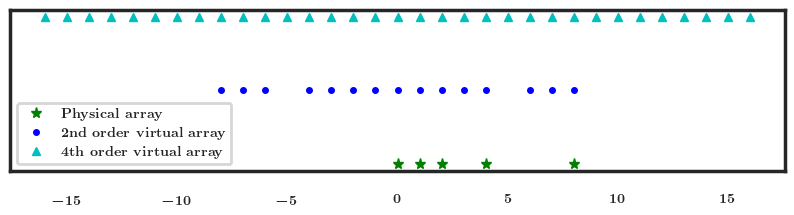

In [16]:
sns.set_style("white")

sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})
plt.figure(figsize=(10, 2.1))

ula_signal = TwoqULASignal(M=[2]*4)
ula_signal.get_idx()
virtual_locations = ula_signal.virtual_locations

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
plt.plot(ula_signal.depths, [0]*len(ula_signal.depths),  'g*', label=r'\textbf{Physical array}', ms=8)
plt.plot(virtual_locations[0], [(1)*0.2]*len(virtual_locations[0]), 'b.', label=r'\textbf{2nd order virtual array}', ms=8)
plt.plot(virtual_locations[1], [(2)*0.2]*len(virtual_locations[1]), 'c^', label=r'\textbf{4th order virtual array}', ms=6)
plt.gca().axes.yaxis.set_ticklabels([])

plt.legend()
plt.savefig('figs/virtual_locations.pdf')

## Fig. 5
## Parallel query complexity versus number of quantum computers

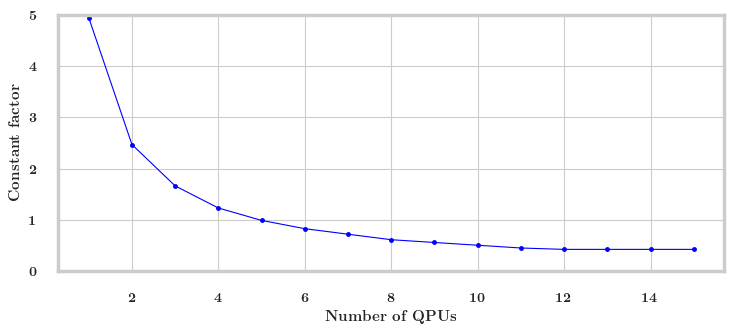

In [17]:
# to divide the queries evenly among the n quantum computers, we view depths as the weight of n objects and n_samples the number of each such item
# we want to divide these objects as evenly as possible according to the weight
# this is related to the partition problem, which is an NP-complete problem
# we will use the greedy approach mentioned here: https://en.wikipedia.org/wiki/Partition_problem#Approximation_algorithm_approaches

ula_signal = TwoqULASignal(M=[2]*5)
ula_signal.get_idx()

n_samples = np.array(ula_signal.n_samples)
n0 = n_samples[0]
n_samples = 2*n_samples
n_samples[0] = n0

depths = ula_signal.depths
depths[0] = 1

def part_sums(n_samples, depths, num_parts):
    S = []
    for i, d in enumerate(depths):
        S = S + [d]*n_samples[i]

    partitions = []
    for _ in range(num_parts):
        partitions.append([])

    while len(S)!=0:
        S.sort(reverse=True)
        part_sums = []
        for part in partitions:
            part_sums.append(np.sum(part))
        idx = list(np.argsort(part_sums))
        partitions = [partitions[i] for i in idx]

        x = S.pop(0)
        partitions[0].append(x)
    part_sums = []
    for part in partitions:
        part_sums.append(np.sum(part))      

    return part_sums

quantum_computers = list(range(1, 16))
fractions = np.zeros(len(quantum_computers))

for i, num_parts in enumerate(quantum_computers):
    p_sums = part_sums(n_samples=n_samples, depths=depths, num_parts=num_parts)
    fractions[i] = max(p_sums)/(np.sum(n_samples*depths))

# now plot constant factor against number of quantum computers
ms=5
lw=0.8

a=0.5

#C= 6960*4.6*10**(-4) # this is the constant factor for the query complexity for amplitude 0.5 for q=5
C = C_csae_ave95 # This is the constant factor determined from the fit

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

plt.plot(quantum_computers, C*fractions, '.-b', ms=ms, linewidth=lw)

plt.ylim([0.0, 5.0])
plt.xlabel(r'\textbf{Number of QPUs}')
plt.ylabel(r'\textbf{Constant factor}')
plt.tight_layout()
plt.savefig('figs/constant_factors_qpus.pdf')

# Fig. 6 Impact of Noise

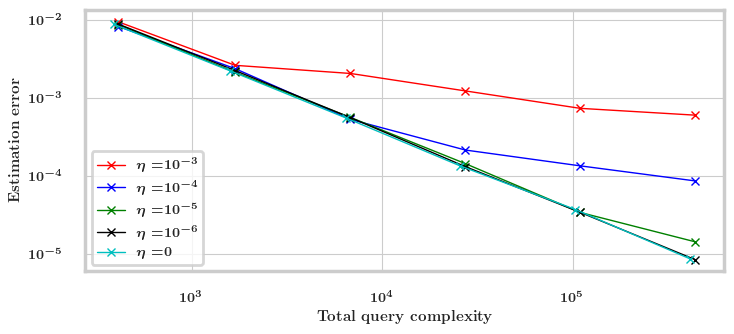

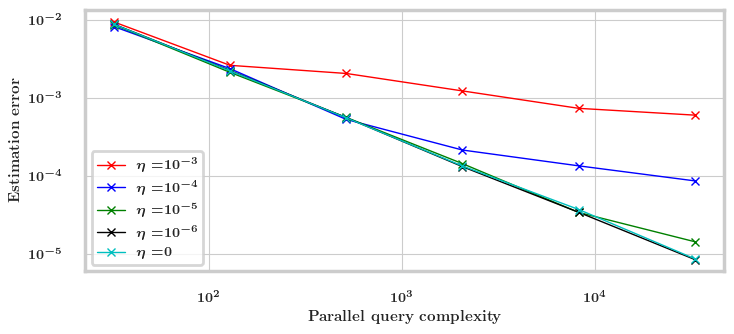

In [18]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

eta_label = ['$10^{-3}$', '$10^{-4}$', '$10^{-5}$', '$10^{-6}$', '$0$']
etas = [1e-3, 1e-4, 1e-5, 1e-6, 0]
dirs = ['sims_C1.5_eta1e-3_final/', 'sims_C1.5_eta1e-4_final/', 'sims_C1.5_eta1e-5_final/', 'sims_C1.5_eta1e-6_final/', 'sims_C1.3_final/']

a=0.5
for idx in range(len(etas)):
    etal = eta_label[idx]
    eta = etas[idx]
    dir = dirs[idx]
    
    with open(dir+f'a{a:0.3f}_mc0500.pkl', 'rb') as handle:
        errors_eta, thetas_eta, num_queries_eta, max_single_query_eta, _, _, _ = pickle.load(handle)

    ninetyfivepercentile_eta = np.percentile(errors_eta, 95, axis=1)
    colors = ['-xr', '-xb', '-xg', '-xk', '-xc']
    plt.figure(0)
    plt.plot(num_queries_eta[2:], ninetyfivepercentile_eta[2:], colors[idx], label=r'\textbf{$\eta=$}'+etal, ms=6, lw=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'\textbf{Total query complexity}')
    plt.ylabel(r'\textbf{Estimation error}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs/a5_query95_eta.pdf')

    plt.figure(1)
    plt.plot(max_single_query_eta[2:], ninetyfivepercentile_eta[2:], colors[idx], label=r'\textbf{$\eta=$}'+etal, ms=6, lw=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'\textbf{Parallel query complexity}')
    plt.ylabel(r'\textbf{Estimation error}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs/a5_parallel_query95_eta.pdf')

# Table 2
To generate table 2, we first loop through all our precomputed data for the various noise values to find the number of samples required to achieve a target estimate error rate of 1e-3 at a given confidence level. Because we used an exponential schedule to generate scaling curves, in some cases, the max depth is too high. In that case, we tweak the parameters of the 2q array to try and find a "sweet spot" in between the powers of 2. The 2q array approach allows us to do this by varying the array parameters and not just use powers of 2

In [19]:
# Here we go loop over our precomputed data with the exponential arrays and 
# figure out how many samples are required. We report the samples as well as 
# the error rate required to get a 1e-3 error rate

ninetyninepercentile_eta = {}
ninetyfivepercentile_eta = {}
sixtyeightpercentile_eta = {}
median_eta = {}

etas = [0.0, 1e-3, 1e-4, 1e-5, 1e-6]
dirs = ['sims_C1.8_final/', 'sims_C1.5_eta1e-3_final/', 'sims_C1.5_eta1e-4_final/', 'sims_C1.5_eta1e-5_final/', 'sims_C1.5_eta1e-6_final/']
epsilon = 1e-3

def find_max_query(error_percentile, queries, max_single_query):
    largest_query = 0
    largest_max_single_query = 0
    largest_error = 0
    
    for key, val in error_percentile.items():

        # If a given amplitude cannot achieve the target error rate, then we just exit
        if min(val) > epsilon:
            return np.inf, np.inf, np.inf
            
        # Otherwise loop through and figure out what the maximum number of queries 
        # one needs to achieve the target error rate
        for idx in range(len(val)):
            error = val[idx]
            
            if (error < epsilon) and (largest_query <= queries[idx]):
                largest_query = queries[idx]
                largest_max_single_query = max_single_query[idx]

                if error > largest_error:
                    largest_error = error
                # break out of the loop because we found the first point where error < epsilon
                break

    return largest_query, largest_max_single_query, largest_error

for idx in range(len(etas)):
#for idx in [0]:
    eta = etas[idx]
    dir = dirs[idx]
    
    for a in amplitudes:
    
        with open(dir+f'a{a:0.3f}_mc0500.pkl', 'rb') as handle:
            errors_eta, thetas_eta, num_queries_eta, max_single_query_eta, _, _, _ = pickle.load(handle)
    
        ninetyninepercentile_eta[a] = np.percentile(errors_eta, 99, axis=1)
        ninetyfivepercentile_eta[a] = np.percentile(errors_eta, 95, axis=1)
        sixtyeightpercentile_eta[a] = np.percentile(errors_eta, 68, axis=1)
        median_eta[a] = np.percentile(errors_eta, 50, axis=1)

    # Find the largest number of queries needed to get a target error of 1-3 at a given confidence interval
    largest_query99, largest_max_single_query99, largest_error99 = find_max_query(ninetyninepercentile_eta, num_queries_eta, max_single_query_eta)
    largest_query95, largest_max_single_query95, largest_error95 = find_max_query(ninetyfivepercentile_eta, num_queries_eta, max_single_query_eta)
    largest_query68, largest_max_single_query68, largest_error68 = find_max_query(sixtyeightpercentile_eta, num_queries_eta, max_single_query_eta)
    largest_query50, largest_max_single_query50, largest_error50 = find_max_query(median_eta, num_queries_eta, max_single_query_eta)
    

    print(f'eta = {eta:0.0E}')
    print(f'   99% Error: {largest_error99:0.3E}')
    print(f'   99% Total number of queries required: {largest_query99}')
    print(f'   99% Max depth queries required: {largest_max_single_query99}\n')

    print(f'   95% Error: {largest_error95:0.3E}')
    print(f'   95% Total number of queries required: {largest_query95}')
    print(f'   95% Max depth queries required: {largest_max_single_query95}\n')

    print(f'   68% Error: {largest_error68:0.3E}')
    print(f'   68% Total number of queries required: {largest_query68}')
    print(f'   68% Max depth queries required: {largest_max_single_query68}\n')

    print(f'   50% Error: {largest_error50:0.3E}')
    print(f'   50% Total number of queries required: {largest_query50}')
    print(f'   50% Max depth queries required: {largest_max_single_query50}\n')

eta = 0E+00
   99% Error: 6.766E-04
   99% Total number of queries required: 32212
   99% Max depth queries required: 2048

   95% Error: 8.711E-04
   95% Total number of queries required: 32212
   95% Max depth queries required: 2048

   68% Error: 3.195E-04
   68% Total number of queries required: 8036
   68% Max depth queries required: 512

   50% Error: 9.467E-04
   50% Total number of queries required: 1995
   50% Max depth queries required: 128

eta = 1E-03
   99% Error: INF
   99% Total number of queries required: inf
   99% Max depth queries required: inf

   95% Error: 9.039E-04
   95% Total number of queries required: 109201
   95% Max depth queries required: 8192

   68% Error: 7.256E-04
   68% Total number of queries required: 6807
   68% Max depth queries required: 512

   50% Error: 4.117E-04
   50% Total number of queries required: 6807
   50% Max depth queries required: 512

eta = 1E-04
   99% Error: 7.689E-04
   99% Total number of queries required: 27284
   99% Max de

## $\eta = 10^{-3}$
For $\eta = 1e-3$ the number of queries can be slightly reduced at 95% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.2$. This cell takes a few minutes to run.

In [20]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-3
np.random.seed(7)
narray = [3, 3, 3, 3, 3, 3, 3, 3] # 8399 C=1.1
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.8)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'95% percentile: {np.percentile(errors, 95):e}')
    print()

Array parameters: [3, 3, 3, 3, 3, 3, 3, 3]
Depths: [   0    1    2    3    6    9   18   27   54   81  162  243  486  729
 1458 2187 4374]
Samples at each depth: [31, 29, 27, 26, 24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 89453
Max Single Query: 4374
a = 0.1; a_est = 0.10002218196960742
95% percentile: 8.169525e-04

Array parameters: [3, 3, 3, 3, 3, 3, 3, 3]
Depths: [   0    1    2    3    6    9   18   27   54   81  162  243  486  729
 1458 2187 4374]
Samples at each depth: [31, 29, 27, 26, 24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 89453
Max Single Query: 4374
a = 0.2; a_est = 0.19999030938681103
95% percentile: 9.100088e-04

Array parameters: [3, 3, 3, 3, 3, 3, 3, 3]
Depths: [   0    1    2    3    6    9   18   27   54   81  162  243  486  729
 1458 2187 4374]
Samples at each depth: [31, 29, 27, 26, 24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 89453
Max Single Query: 4374
a = 0.30000000000000004; a_est = 0.299990714

## $\eta = 10^{-4}$
For $\eta = 1e-4$ the number of queries can be reduced at 99% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.7$. This cell takes a few minutes to run.

In [21]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-4
np.random.seed(7)
narray = [3, 3, 2, 2, 2, 2, 2, 2, 2, 2] # 18262 C=1.8
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.8)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)

        
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'99% percentile: {np.percentile(errors, 99):e}')
    print()

Array parameters: [3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [   0    1    2    3    6    9   18   36   72  144  288  576 1152]
Samples at each depth: [24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 18262
Max Single Query: 1152
a = 0.1; a_est = 0.09999819640486839
99% percentile: 7.256559e-04

Array parameters: [3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [   0    1    2    3    6    9   18   36   72  144  288  576 1152]
Samples at each depth: [24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 18262
Max Single Query: 1152
a = 0.2; a_est = 0.2000282279675473
99% percentile: 5.458186e-04

Array parameters: [3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [   0    1    2    3    6    9   18   36   72  144  288  576 1152]
Samples at each depth: [24, 22, 20, 18, 17, 15, 13, 11, 9, 8, 6, 4, 2]
Number of queries: 18262
Max Single Query: 1152
a = 0.30000000000000004; a_est = 0.2999928397582868
99% percentile: 7.378559e-04

Array parameters: [3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Depths:

For $\eta = 1e-4$ the number of queries can be reduced at 95% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.1$. This cell takes a few minutes to run.

In [22]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-4
np.random.seed(7)
narray = [3, 3, 3, 3, 2, 2, 2, 2] # 8399 C=1.1
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.1)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'95% percentile: {np.percentile(errors, 95):e}')
    print()

Array parameters: [3, 3, 3, 3, 2, 2, 2, 2]
Depths: [  0   1   2   3   6   9  18  27  54  81 162 324 648]
Samples at each depth: [15, 14, 13, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 8399
Max Single Query: 648
a = 0.1; a_est = 0.09992597576388526
95% percentile: 9.590904e-04

Array parameters: [3, 3, 3, 3, 2, 2, 2, 2]
Depths: [  0   1   2   3   6   9  18  27  54  81 162 324 648]
Samples at each depth: [15, 14, 13, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 8399
Max Single Query: 648
a = 0.2; a_est = 0.19995293205651435
95% percentile: 6.924465e-04

Array parameters: [3, 3, 3, 3, 2, 2, 2, 2]
Depths: [  0   1   2   3   6   9  18  27  54  81 162 324 648]
Samples at each depth: [15, 14, 13, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 8399
Max Single Query: 648
a = 0.30000000000000004; a_est = 0.29999607304326914
95% percentile: 5.375237e-04

Array parameters: [3, 3, 3, 3, 2, 2, 2, 2]
Depths: [  0   1   2   3   6   9  18  27  54  81 162 324 648]
Samples at each depth

For $\eta = 1e-4$ the number of queries can be reduced at 68% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.3$. This cell takes a few minutes to run.

In [23]:
np.random.seed(7)
eta=1e-4
narray = [3, 2, 2, 2, 2, 2, 2, 2] # 2311 C=1.1
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.1)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'68% percentile: {np.percentile(errors, 68):e}')
    print()

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.1; a_est = 0.09991491487728353
68% percentile: 7.916808e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.2; a_est = 0.2003798759233528
68% percentile: 8.687281e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.30000000000000004; a_est = 0.29994119788151546
68% percentile: 9.172225e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 

## $\eta \le 10^{-5}$
For $\eta \le 1e-5$ the number of samples can be reduced at 99% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.1$. This cell takes a few minutes to run.

In [24]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-5
np.random.seed(7)
narray = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2] # 10214 C=2.1
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=2.1)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)

        
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'99% percentile: {np.percentile(errors, 99):e}')
    print()

Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128 256 512]
Samples at each depth: [24, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3]
Number of queries: 10214
Max Single Query: 512
a = 0.1; a_est = 0.10002609884280733
99% percentile: 8.359983e-04

Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128 256 512]
Samples at each depth: [24, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3]
Number of queries: 10214
Max Single Query: 512
a = 0.2; a_est = 0.2000266947722287
99% percentile: 6.505989e-04

Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128 256 512]
Samples at each depth: [24, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3]
Number of queries: 10214
Max Single Query: 512
a = 0.30000000000000004; a_est = 0.3000033562712782
99% percentile: 7.964034e-04

Array parameters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128 256 512]
Samples at each depth: [24, 21, 19, 17, 

For $\eta \le 1e-5$ the number of samples can be reduced at 95% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.2$. This cell takes a few minutes to run.

In [25]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-5
np.random.seed(7)
narray = [6, 5, 3, 2, 2, 2] # 6004 C=1.3
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.3)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)

        
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'95% percentile: {np.percentile(errors, 95):e}')
    print()

Array parameters: [6, 5, 3, 2, 2, 2]
Depths: [  0   1   2   3   4   5   6  12  18  24  30  60  90 180 360]
Samples at each depth: [20, 19, 17, 16, 15, 13, 12, 11, 10, 8, 7, 6, 4, 3, 2]
Number of queries: 6004
Max Single Query: 360
a = 0.1; a_est = 0.10004963567703462
95% percentile: 6.736554e-04

Array parameters: [6, 5, 3, 2, 2, 2]
Depths: [  0   1   2   3   4   5   6  12  18  24  30  60  90 180 360]
Samples at each depth: [20, 19, 17, 16, 15, 13, 12, 11, 10, 8, 7, 6, 4, 3, 2]
Number of queries: 6004
Max Single Query: 360
a = 0.2; a_est = 0.20004865603706914
95% percentile: 9.779548e-04

Array parameters: [6, 5, 3, 2, 2, 2]
Depths: [  0   1   2   3   4   5   6  12  18  24  30  60  90 180 360]
Samples at each depth: [20, 19, 17, 16, 15, 13, 12, 11, 10, 8, 7, 6, 4, 3, 2]
Number of queries: 6004
Max Single Query: 360
a = 0.30000000000000004; a_est = 0.3000454134261173
95% percentile: 8.283761e-04

Array parameters: [6, 5, 3, 2, 2, 2]
Depths: [  0   1   2   3   4   5   6  12  18  24  30  

For $\eta \le 1e-5$ the number of samples can be reduced at 68% confidence as demonstrated here. The estimation error for all amplitudes are below the $1e-3$ level with the max error at $a=0.3$. This cell takes a few minutes to run.

In [26]:
amplitudes = np.linspace(0.1, 0.9, 9)
eta=1e-5
np.random.seed(7)
narray = [3, 2, 2, 2, 2, 2, 2, 2] # 2311 C=1.1
espirit = ESPIRIT()

for a in amplitudes:
    theta = np.arcsin(a)
    print(f'Array parameters: {narray}')
    ula_signal = TwoqULASignal(M=narray, C=1.1)
    num_mc = 500
    thetas = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    
    for k in range(num_mc):
        R = ula_signal.get_cov_matrix_toeplitz(theta, n_samples=ula_signal.n_samples, eta=eta)
        theta_est = espirit.estimate_theta_toeplitz(R)

        
        
        error = np.abs(np.sin(theta)-np.sin(theta_est)) 
        
        thetas[k] = theta_est            
        errors[k] = error
    
    num_queries = 2*np.sum(np.array(ula_signal.depths)*np.array(ula_signal.n_samples)) + ula_signal.n_samples[0]
    max_single_query = np.max(ula_signal.depths)

    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'Number of queries: {num_queries}')
    print(f'Max Single Query: {max_single_query}')
    print(f'a = {a}; a_est = {np.sin(np.mean(thetas))}')
    print(f'68% percentile: {np.percentile(errors, 68):e}')
    print()

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.1; a_est = 0.09993599082591796
68% percentile: 7.862815e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.2; a_est = 0.20033686453116228
68% percentile: 8.190978e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 0.30000000000000004; a_est = 0.2998801708572741
68% percentile: 9.055884e-04

Array parameters: [3, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   3   6  12  24  48  96 192]
Samples at each depth: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Number of queries: 2311
Max Single Query: 192
a = 